# Random Forest Project

## Data loading 

In [1]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Load the diabetes dataset directly from the URL
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
df = pd.read_csv(url)

# Show the first 5 rows to verify the data loaded correctly
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


> We successfully loaded the diabetes dataset containing 768 patient records and 9 variables related to diabetes risk factors and diagnosis. The dataset’s variables include numeric clinical measurements such as number of pregnancies, plasma glucose level, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function, age, and the target Outcome variable indicating diabetes presence (1) or absence (0).

> We proceed to inspect the data:

## Exploration and Data Cleaning

In [2]:
# Show basic info about dataset: columns, data types, and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


> Using ***df.info()***, we confirmed there are no missing values — all columns have 768 non-null entries and the data types are appropriate (mostly integers, two float columns). This means the dataset is complete with no immediate need for handling missing data at this stage.

In [3]:
# Show basic descriptive statistics
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

> From the descriptive statistics (df.describe()), we observe:

- Variables like Glucose, BloodPressure, SkinThickness, Insulin, BMI show a wide range of values. Notably, the minimum values of some variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) are zero, which might represent missing or unrecorded measurements and will require attention in the exploratory data analysis step.

- The mean BMI is about 32, indicating overweight on average.

- The mean age is around 33 years, with patients ranging from 21 to 81 years old.

- The target variable Outcome has a mean of ~0.35, indicating approximately 35% of patients in this dataset are diagnosed with diabetes, which is somewhat imbalanced and important to consider during model training.

> We proceed to check and remove duplicates.

In [4]:
# 3. Check and remove duplicates
duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")

if duplicates_count > 0:
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate rows: 0


> There are no duplicate rows ***AND*** we won't remove any information because all variables are medically relevant to diabetes prediction.

> So, we proceed.

## Univariate Analysis

> We check the DataFrame to see the variables.

In [5]:
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


> We will begin with the categorical analysis since there is only 1 (Outcome)

### Categorical Variable Analysis

> Checking for value counts since the target variable Outcome is categorical and binary, representing whether a patient has diabetes (1) or not (0).


In [6]:
print("Value counts for Outcome:")
print(df['Outcome'].value_counts())

Value counts for Outcome:
Outcome
0    500
1    268
Name: count, dtype: int64


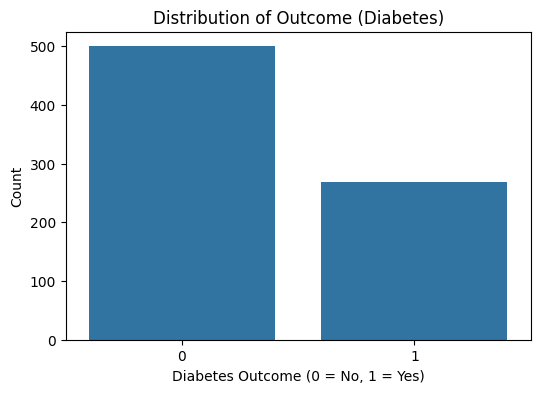

In [7]:
# Plot distribution of Outcome to visualize class balance
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome (Diabetes)')
plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

> The distribution shows approximately 65% of patients are negative for diabetes and 35% are positive, indicating a moderate class imbalance which will be important to consider during modeling.

### Numerical Variables Analysis

> We know there are 11 variables, so we will check them first.

In [8]:
# Summary statistics for numeric variables (all except Outcome)
print("\nSummary statistics for numeric variables:")
print(df.describe())


Summary statistics for numeric variables:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.4

> Everything seems right, so we proceed with visualization.

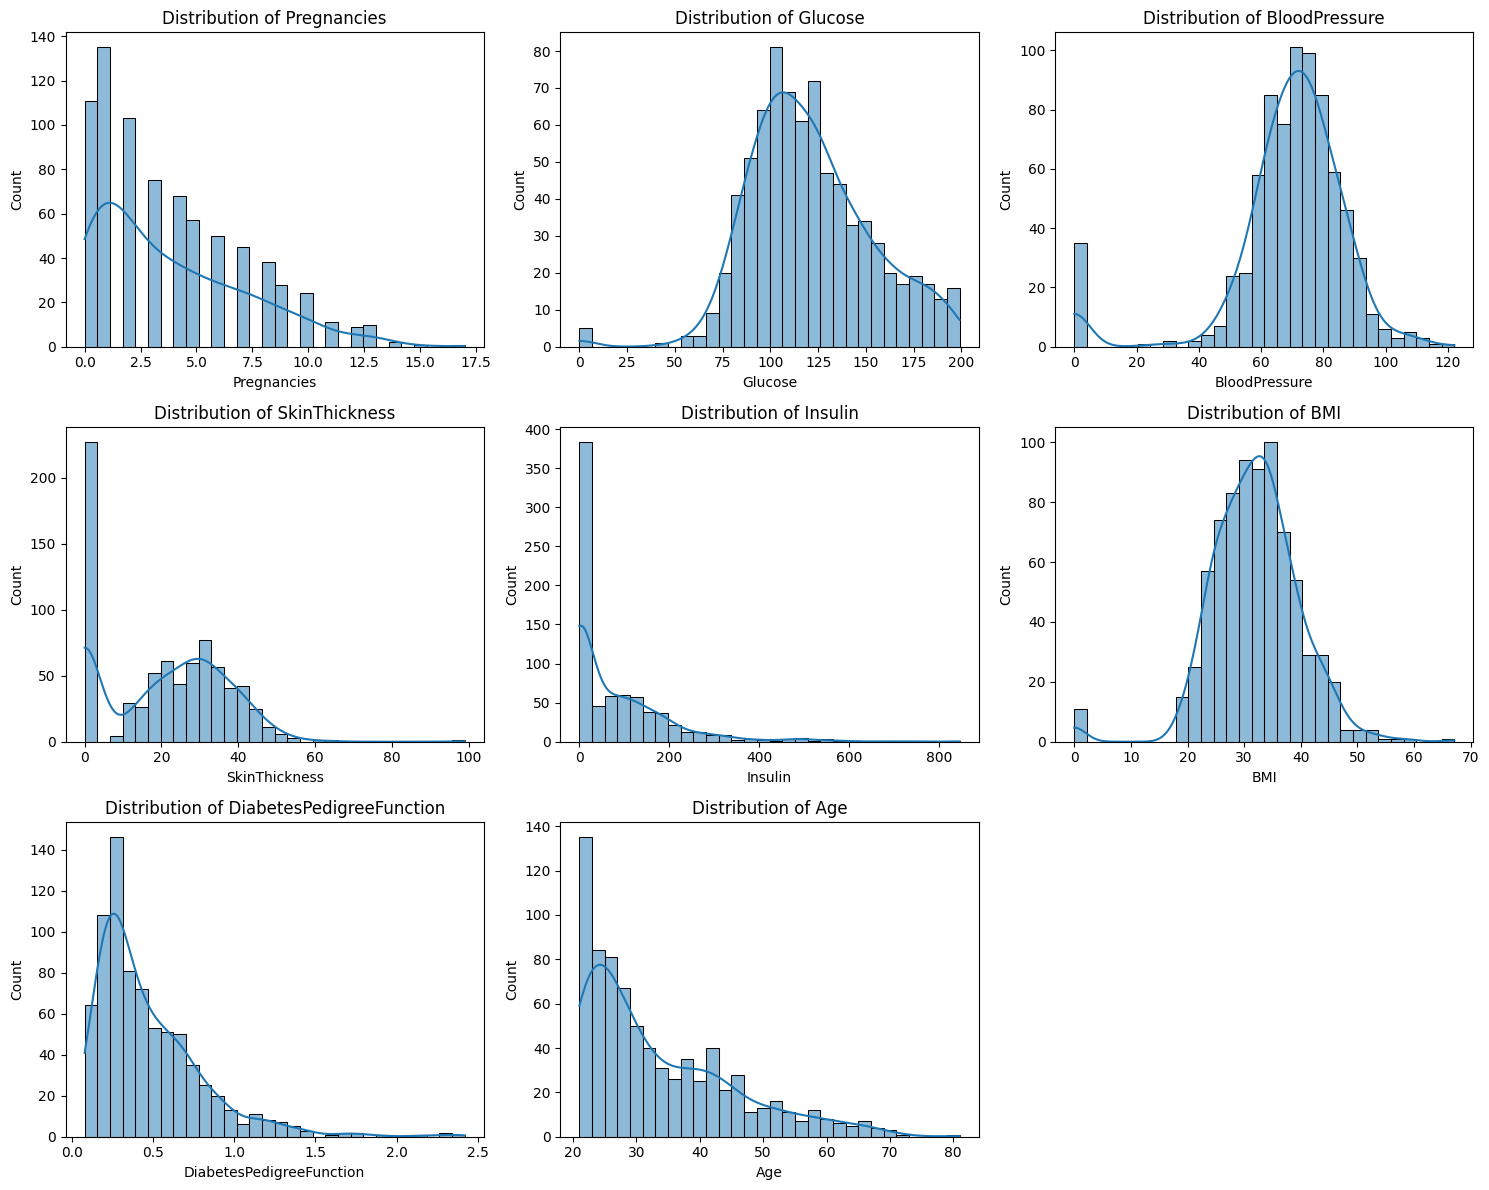

In [9]:
# Plot histograms with KDE to understand distribution of numeric features
numeric_cols = df.drop('Outcome', axis=1).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

> For the numeric variables, the histograms reveal varied distributions:

- Glucose and BMI show right-skewed distributions with some patients having very high values, reflecting potential outliers or extreme cases.

- SkinThickness and Insulin contain many zero values, which likely represent missing or unrecorded data rather than true zeros, and these will need to be addressed in data cleaning.

- Age and Pregnancies appear more normally or uniformly distributed across their ranges.

> We proceed with the next step.

## Multivariate Analysis

> Next we will proceed with the multivariate analysis.

### Numerical-Numerical Analysis: Scatterplots and Correlation Matrix

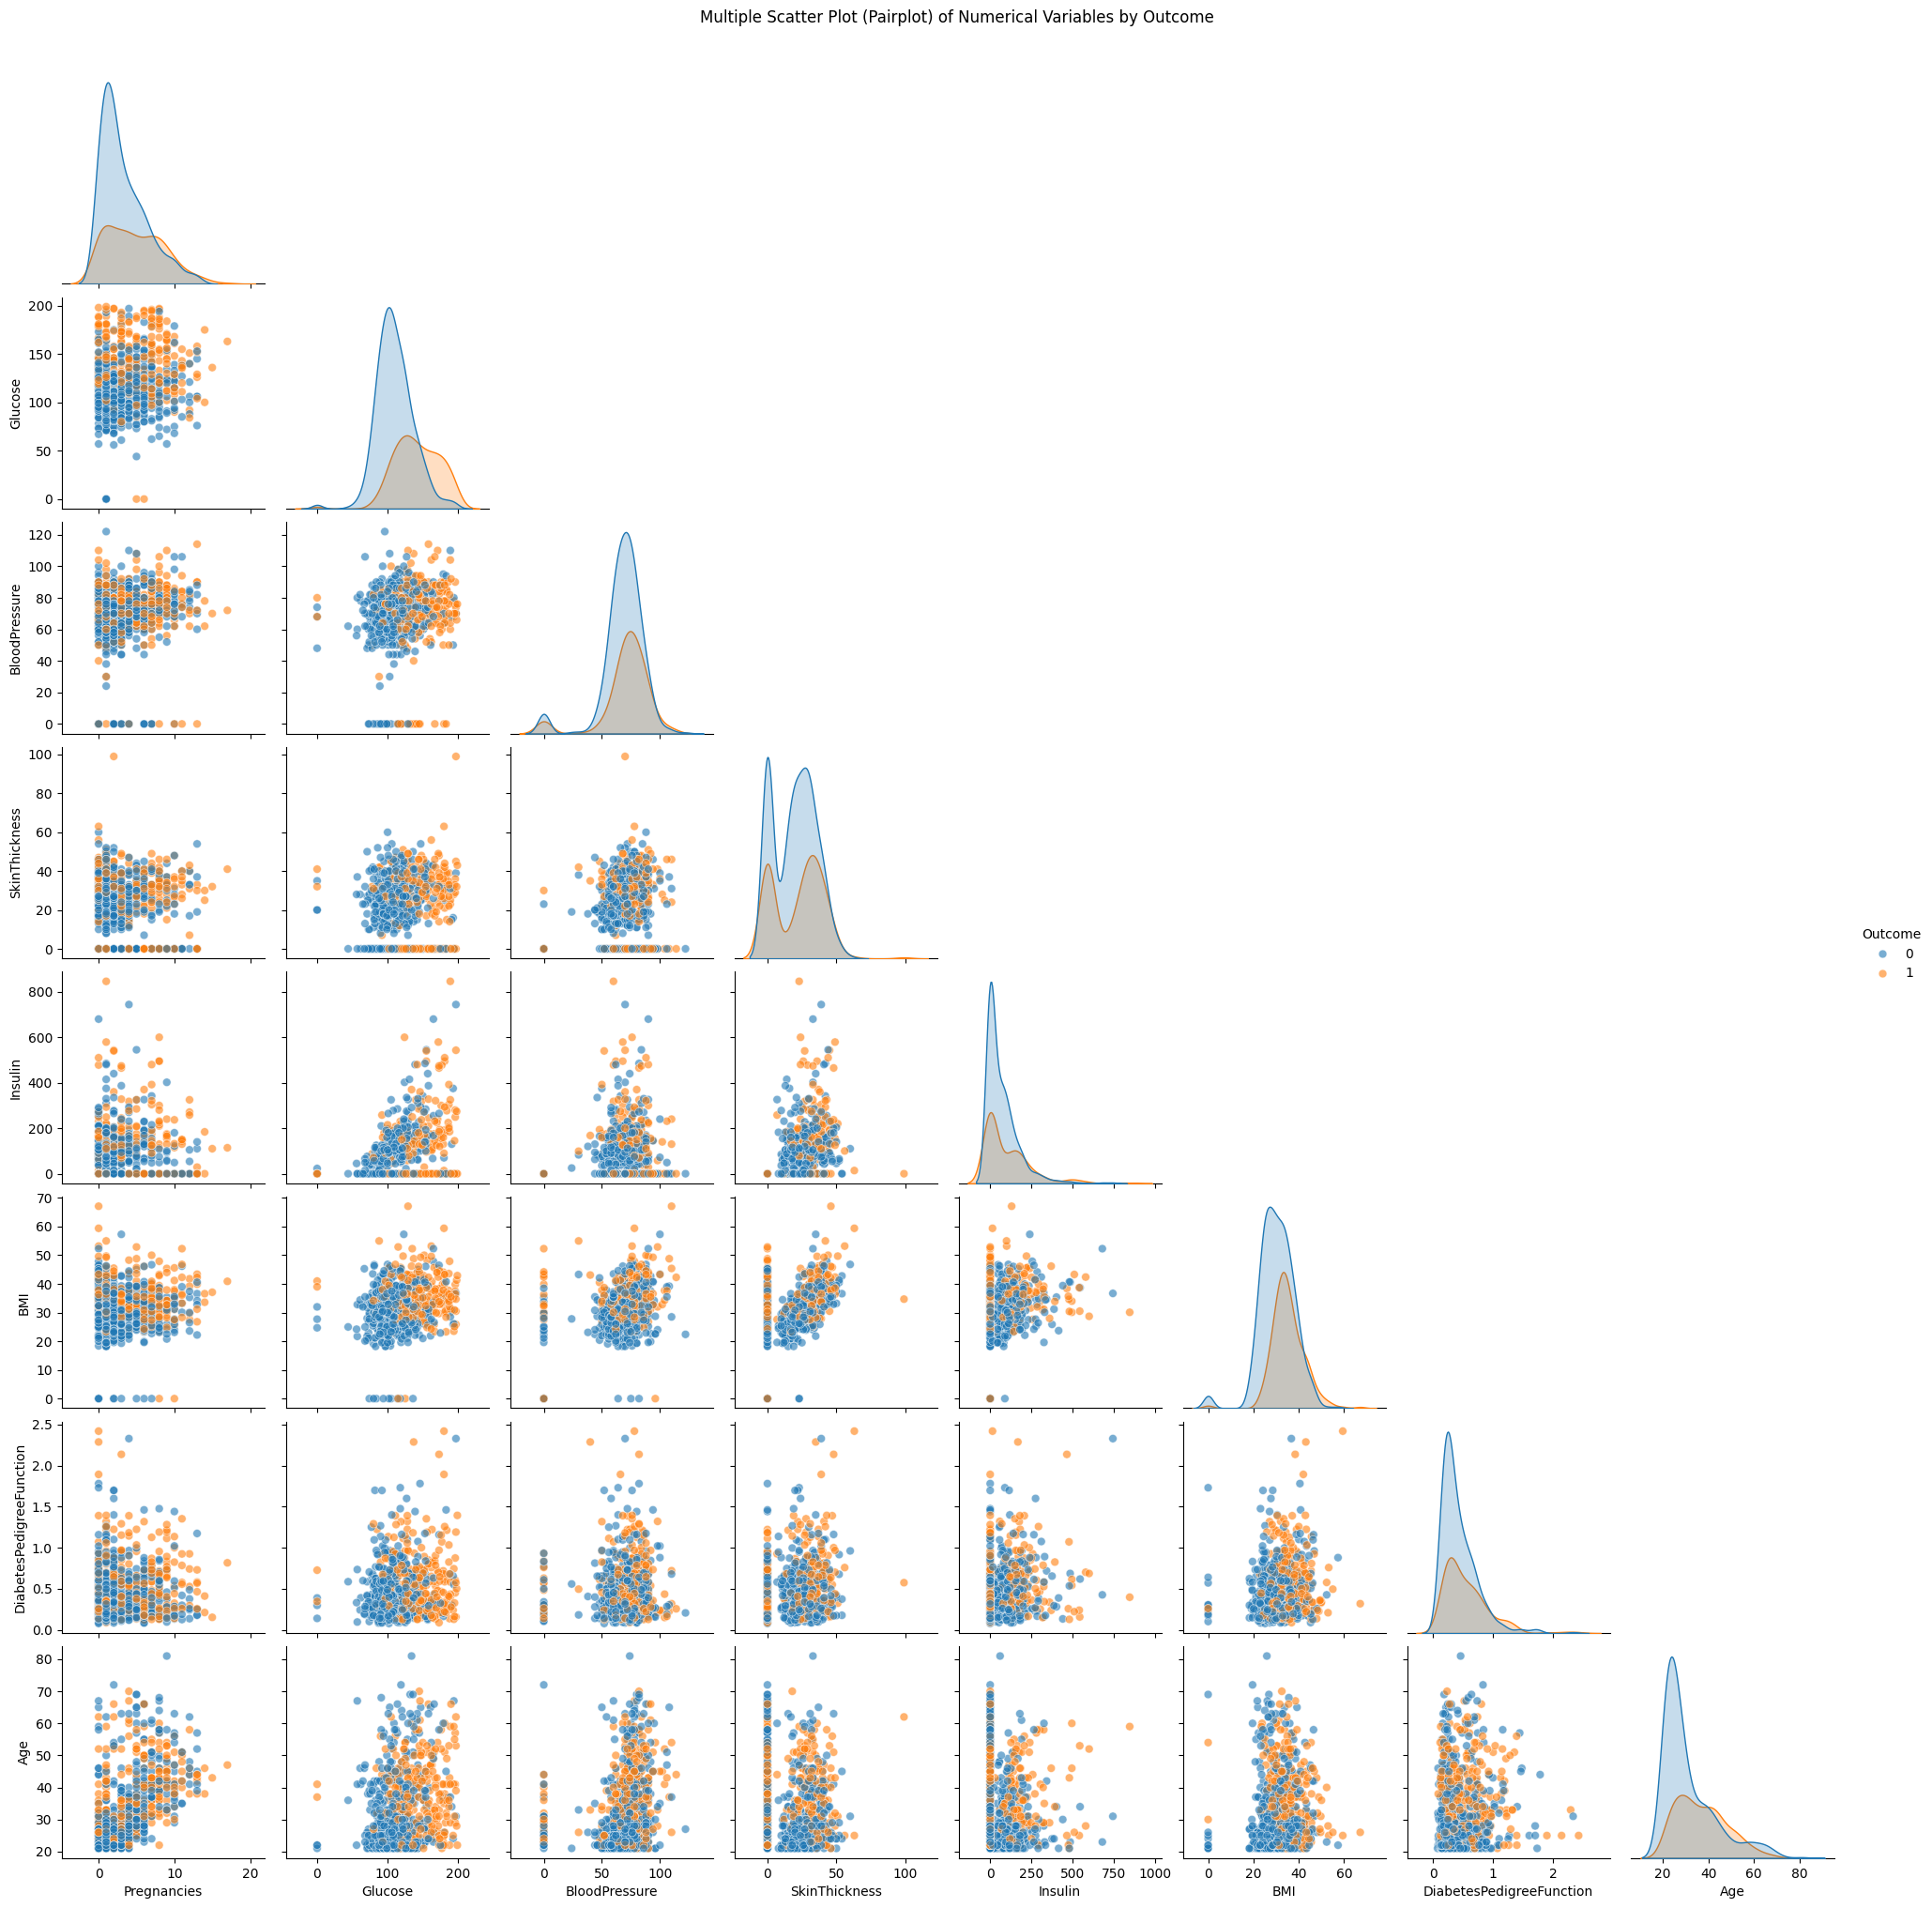

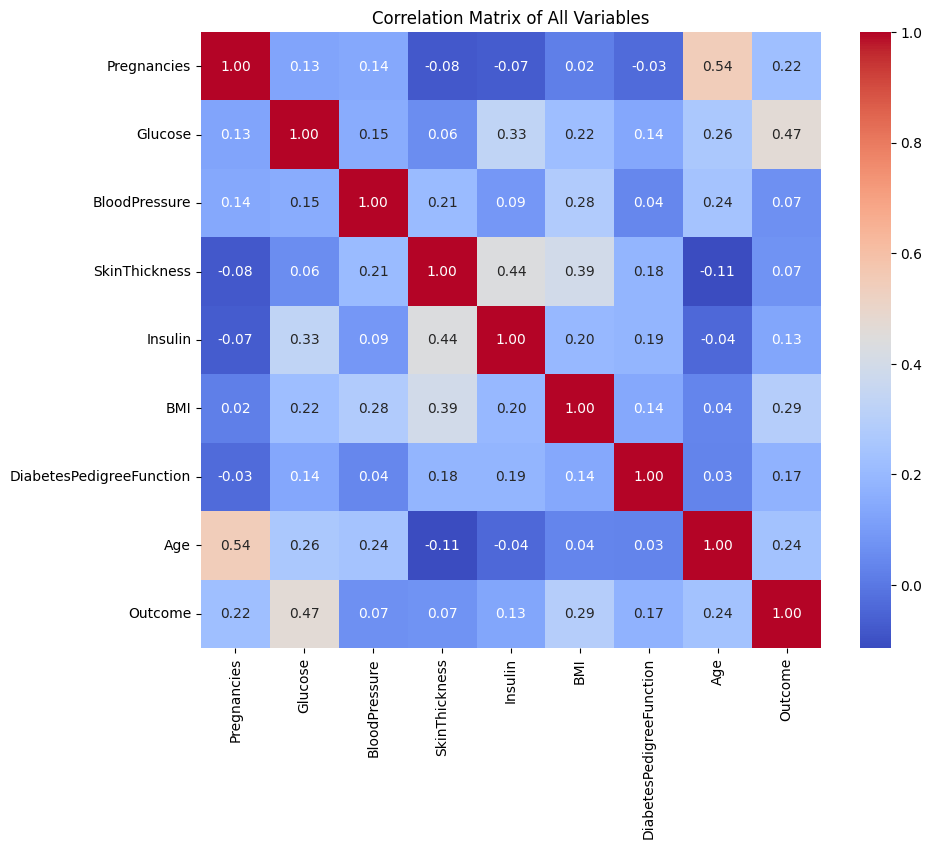

In [10]:
# Select numeric variables for scatter matrix
numeric_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create a pairplot colored by Outcome
sns.pairplot(df, vars=numeric_vars, hue='Outcome', corner=True, diag_kind='kde',
             plot_kws={'alpha':0.6, 's':40})

plt.suptitle('Multiple Scatter Plot (Pairplot) of Numerical Variables by Outcome', y=1.02)
plt.show()


# Correlation matrix heatmap for numerical variables
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of All Variables')
plt.show()

#### Observations:

> Pairplot (Multiple Scatter Diagram):

- The pairplot shows relationships among the eight numeric variables, with points colored by the diabetes Outcome (0 = no diabetes, 1 = diabetes).

- There is a clear separation between diabetic (orange) and non-diabetic (blue) patients in variables such as Glucose and BMI, where diabetic patients generally have higher values.

- Strong positive relationships can be seen between some pairs, such as Glucose and Insulin, where values tend to increase together.

- Other variables like SkinThickness and BloodPressure have more overlapping distributions but still show some clustering by Outcome.

- The density plots on the diagonal show that the distributions of several variables shift to the right (higher values) for diabetic patients, especially for Glucose, BMI, and Age.

- Variables like Pregnancies and DiabetesPedigreeFunction show more mixed or subtle differences between classes.

> Correlation Matrix:
- The heatmap shows Pearson correlation coefficients between all numeric variables ***including Outcome.***

- The strongest positive correlation with Outcome is Glucose (r ≈ 0.47), confirming its importance in diabetes prediction.

- Other variables with moderate positive correlation to Outcome include BMI (r ≈ 0.29), Age (r ≈ 0.24), and DiabetesPedigreeFunction (r ≈ 0.17).

- There are moderate correlations among predictors themselves, for example:
    - Glucose and Insulin (r ≈ 0.44), indicating these tend to increase together.
    - BMI and SkinThickness (r ≈ 0.39), reflecting related body measurements.

- Most other correlations are weak or near zero, suggesting limited linear relationships.

> ***Conclusion***

- The visual and quantitative analyses together highlight that ***Glucose, BMI, Age, and DiabetesPedigreeFunction*** are key predictors with meaningful relationships to diabetes outcome. These variables should be prioritized in modeling and possibly require further exploration to improve prediction accuracy.

> We would proceed with the categorical-categorical analysis, but since the dataset contains only one categorical variable (Outcome), categorical-categorical analysis is ***NOT*** applicable.

> So we will proceed like normal

<!-- ### Numerical-Categorical Analysis: Comparing distributions by Outcome ### -->

### Numerical - Categorical Analysis

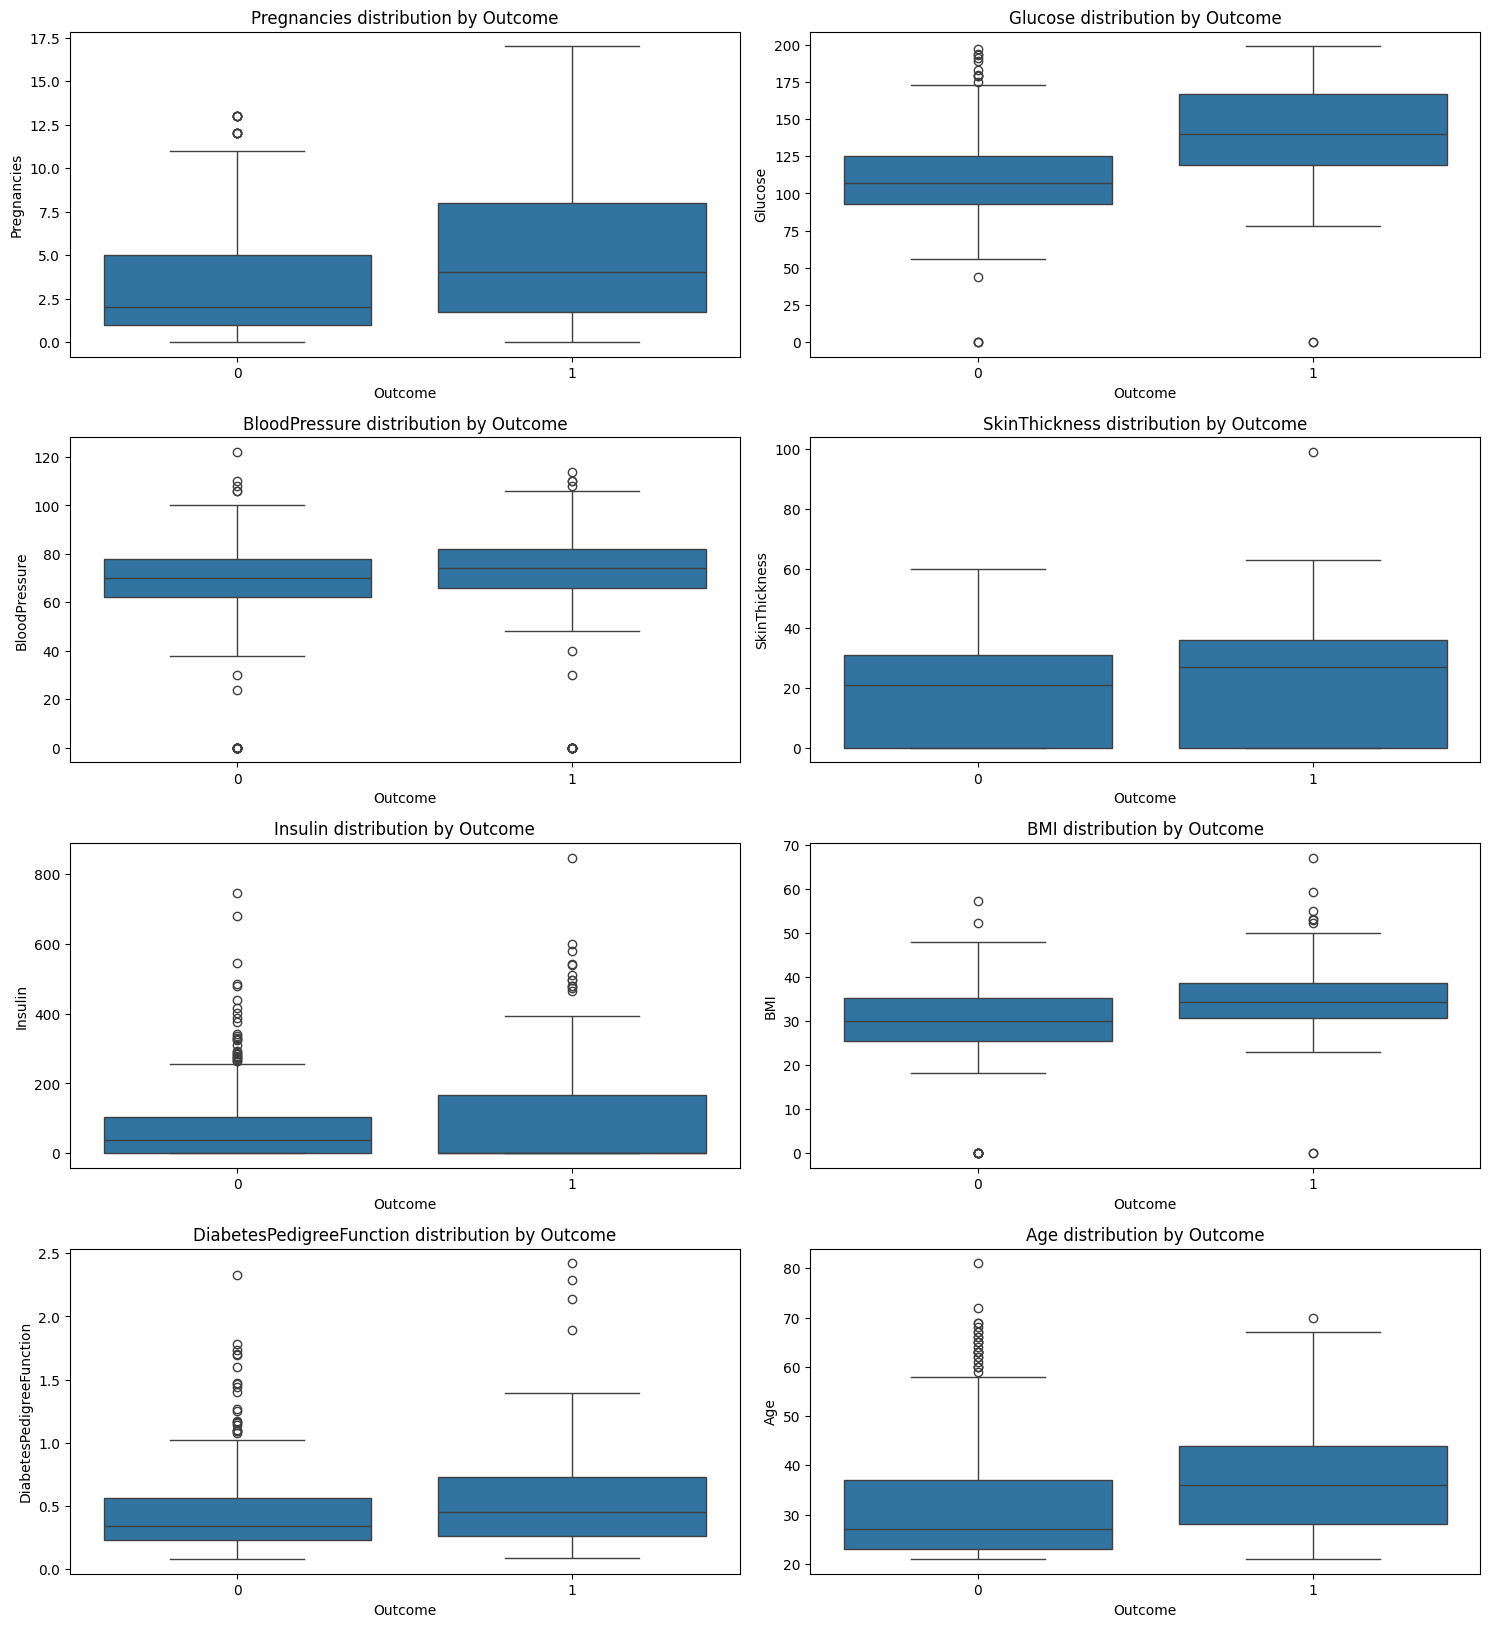

In [11]:
numeric_cols = df.drop('Outcome', axis=1).columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} distribution by Outcome')
plt.tight_layout()
plt.show()

> The boxplots compare the distribution of each numeric predictor variable across the two Outcome classes:

- 0 = Non-diabetic
- 1 = Diabetic

> Key Observations:
 - Pregnancies:
    - Diabetic patients tend to have a higher median number of pregnancies.
    - The distribution is wider for diabetics, indicating more variation in this group.
- Glucose:
    - Diabetic patients have significantly higher glucose levels.
    - There is a clear separation in medians, and the entire glucose distribution shifts higher in diabetics.
    - This is the most visually distinct variable between the two classes.
- Blood Pressure:
    - Both groups have similar distributions, but diabetic patients show slightly higher variability.
    - There is some overlap, suggesting Blood Pressure alone is not a strong discriminator.
- Skin Thickness:
    - Distributions are fairly similar between the two groups.
    - Slightly higher median for diabetics, but with considerable overlap.
- Insulin:
    - Diabetic patients show a higher median insulin level.
    - There are many outliers, indicating high variability and extreme values in both groups.
- BMI:
    - Diabetic patients tend to have a higher BMI.
    - The shift in median and distribution is noticeable, though not as strong as glucose.
- Diabetes Pedigree Function:
    - Diabetic patients have a slightly higher median, but the distributions overlap substantially.
    - There are more high-value outliers in the diabetic group.
- Age:
    - Diabetic patients tend to be older on average.
    - The diabetic group has a wider age distribution and a higher median age.
- Summary:
    - Strong indicators of diabetes: Glucose, BMI, Age, Pregnancies
    - Moderate indicators: Insulin, DiabetesPedigreeFunction
    - Weak indicators: BloodPressure, SkinThickness (due to high overlap between classes)
- ***These visual results confirm the numeric-categorical correlation findings: Glucose, BMI, Age, and Pregnancies are the most important predictors, as their distributions differ most clearly between diabetic and non-diabetic patients.***

### Feature Selection

In [12]:
# Keep variables with strong separation and significance
keep = ['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction']
X = df[keep]
y = df['Outcome']

In [13]:
# Train/test split (20% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print('Training set shape:', X_train.shape, 'Test set shape:', X_test.shape)

Training set shape: (614, 5) Test set shape: (154, 5)


#### Train/Test Split
- Training set: 614 samples (80%)
- Test set: 154 samples (20%)

- Both sets maintain the original class balance: about 65% non-diabetic (Outcome = 0) and 35% diabetic (Outcome = 1). This is thanks to stratification, which prevents bias and ensures fair model evaluation.

## Feature Engineering

In [14]:
# Outlier capping via IQR on training set
X_train_fe = X_train.copy()
for col in X_train_fe.columns:
    Q1, Q3 = X_train_fe[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X_train_fe[col] = X_train_fe[col].clip(lower, upper)

#### Outlier Capping
- For each numeric feature in the training set, extreme values (outliers) are capped to the boundary of 1.5×IQR below the 25th percentile or above the 75th percentile.
- This reduces the impact of rare, extreme measurements that could distort model splits or training.

In [15]:
# New inferred features: BMI category & Age group
X_train_fe['BMI_cat'] = pd.cut(
    X_train_fe['BMI'], bins=[0,18.5,24.9,29.9,np.inf],
    labels=['Underweight','Normal','Overweight','Obese']
)
X_train_fe['Age_group'] = pd.cut(
    X_train_fe['Age'], bins=[0,30,50,np.inf],
    labels=['Young','Adult','Senior']
)
# One-hot encode new categories
X_train_fe = pd.get_dummies(X_train_fe, columns=['BMI_cat','Age_group'], drop_first=True)

# Apply same transformations to test set
X_test_fe = X_test.copy()
for col in keep:
    Q1, Q3 = X_train[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X_test_fe[col] = X_test_fe[col].clip(lower, upper)
X_test_fe['BMI_cat'] = pd.cut(
    X_test_fe['BMI'], bins=[0,18.5,24.9,29.9,np.inf],
    labels=['Underweight','Normal','Overweight','Obese']
)
X_test_fe['Age_group'] = pd.cut(
    X_test_fe['Age'], bins=[0,30,50,np.inf],
    labels=['Young','Adult','Senior']
)
X_test_fe = pd.get_dummies(X_test_fe, columns=['BMI_cat','Age_group'], drop_first=True)

> Two new categorical variables were created:

- BMI Category: Underweight, Normal, Overweight, Obese (based on clinical BMI cutoffs)

- Age Group: Young (<30), Adult (30–50), Senior (>50)

- These categories are one-hot encoded, resulting in 5 new columns (dummies):
    - BMI_cat_Normal, BMI_cat_Overweight, BMI_cat_Obese, Age_group_Adult, Age_group_Senior

> The total feature count after this step is 10: 5 original + 5 new dummies.

#### Feature Scaling

- All engineered features are scaled to the range [0, 1] using Min–Max scaling.

- This ensures that all predictors contribute comparably, which is especially useful for algorithms that consider feature magnitude.

In [16]:
# Feature Scaling via Min-Max
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_fe),
    columns=X_train_fe.columns,
    index=X_train_fe.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_fe),
    columns=X_test_fe.columns,
    index=X_test_fe.index
)
print('After feature engineering:', X_train_scaled.shape, X_test_scaled.shape)

After feature engineering: (614, 10) (154, 10)


 > Summary
- The resulting training data now has 614 rows and 10 features, all scaled to [0,1]. The class distribution is well-preserved, and the new categorical bins help the model learn non-linear patterns related to age and BMI. This prepares the dataset for robust, fair, and effective machine learning modeling!

## Feature Selection

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# We'll use mutual information to score all features and select the top k=7

selector = SelectKBest(score_func=mutual_info_classif, k=7)
selector.fit(X_train_scaled, y_train)

# Get mask of selected features and their scores
mask = selector.get_support()
scores = selector.scores_
selected_features = X_train_scaled.columns[mask]
feature_scores = pd.Series(scores, index=X_train_scaled.columns).sort_values(ascending=False)

print("Feature ranking (by mutual information):")
print(feature_scores)

print("\nSelected features for modeling:")
print(selected_features.tolist())

# Reduce datasets to selected features for modeling
X_train_fs = X_train_scaled[selected_features]
X_test_fs = X_test_scaled[selected_features]
selected_columns = X_train_scaled.columns[selector.get_support()]


Feature ranking (by mutual information):
Glucose                     0.136641
BMI                         0.087879
BMI_cat_Obese               0.073656
Age                         0.049543
Pregnancies                 0.032603
BMI_cat_Overweight          0.014374
BMI_cat_Normal              0.014155
DiabetesPedigreeFunction    0.006802
Age_group_Adult             0.005250
Age_group_Senior            0.000000
dtype: float64

Selected features for modeling:
['Glucose', 'BMI', 'Age', 'Pregnancies', 'BMI_cat_Normal', 'BMI_cat_Overweight', 'BMI_cat_Obese']


> Summary 
- SelectKBest with mutual_info_classif scores each feature’s dependency with the outcome, capturing both linear and nonlinear relationships.
- Only the training set is used for feature scoring and selection, avoiding data leakage.
- The top 7 features (by mutual information) are chosen—this number can be changed as needed.
- The selected feature names and their scores are printed for transparency.
- Both training and test sets are reduced to these selected features before modeling.

> Why this matters:
- Feature selection improves model performance by removing noisy or redundant predictors and reduces the risk of overfitting—especially important with engineered features and a modest dataset size.

## Random Forest Building

> We trained a Random Forest classifier to predict diabetes based on our engineered features. The model combines multiple decision trees, each trained on random subsets of the data and features, to improve accuracy and robustness compared to a single tree.

n_estimators=10, max_depth=3: accuracy=0.740, oob_score=0.759


/home/vscode/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


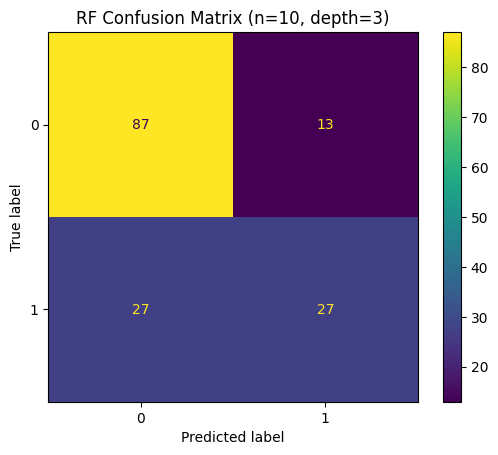

/home/vscode/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators=10, max_depth=7: accuracy=0.734, oob_score=0.735


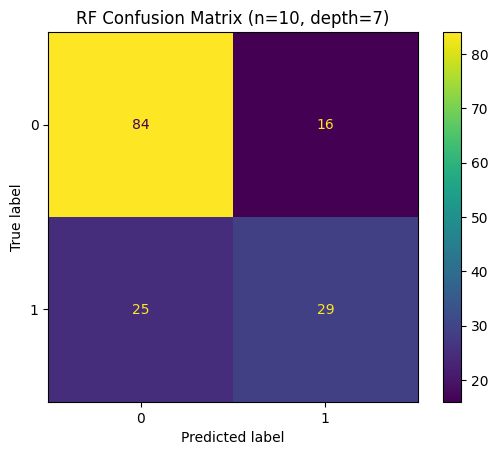

n_estimators=10, max_depth=None: accuracy=0.734, oob_score=0.725


/home/vscode/.local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


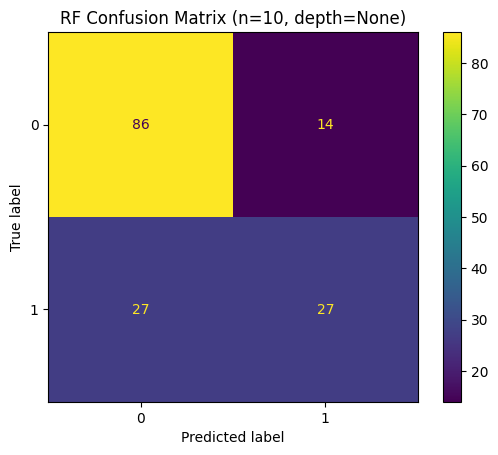

n_estimators=50, max_depth=3: accuracy=0.740, oob_score=0.772


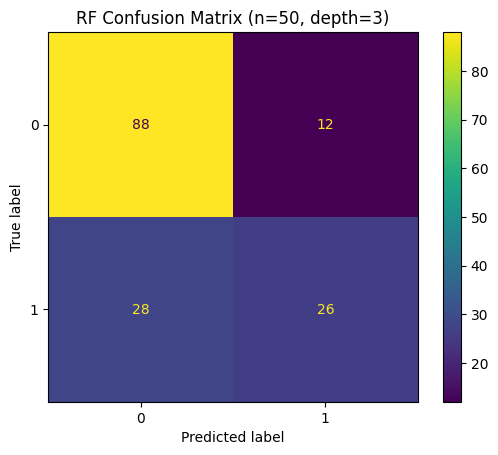

n_estimators=50, max_depth=7: accuracy=0.753, oob_score=0.759


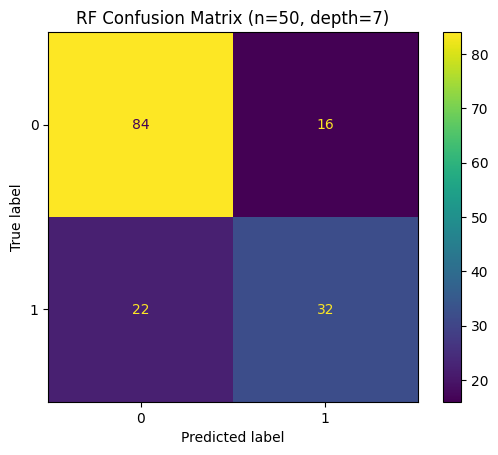

n_estimators=50, max_depth=None: accuracy=0.753, oob_score=0.754


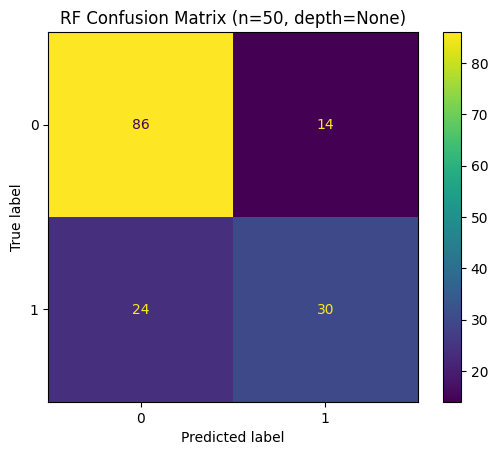

n_estimators=100, max_depth=3: accuracy=0.740, oob_score=0.767


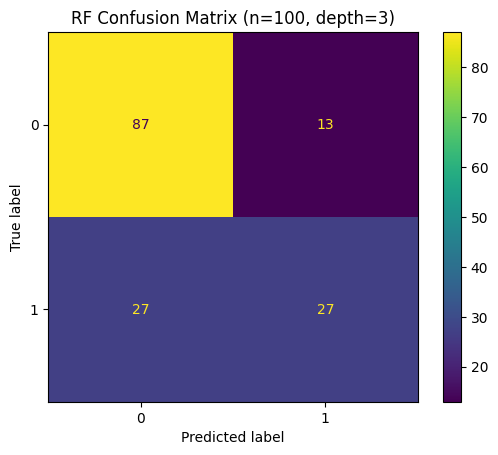

n_estimators=100, max_depth=7: accuracy=0.740, oob_score=0.759


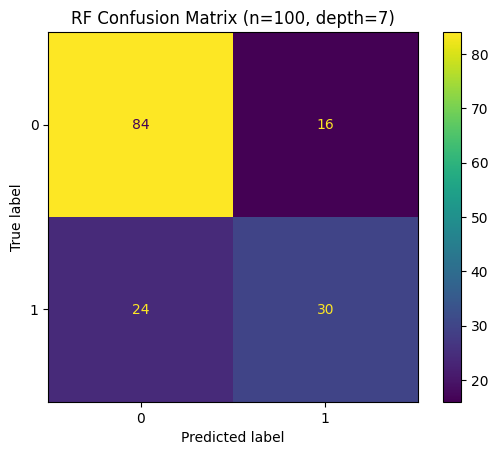

n_estimators=100, max_depth=None: accuracy=0.747, oob_score=0.764


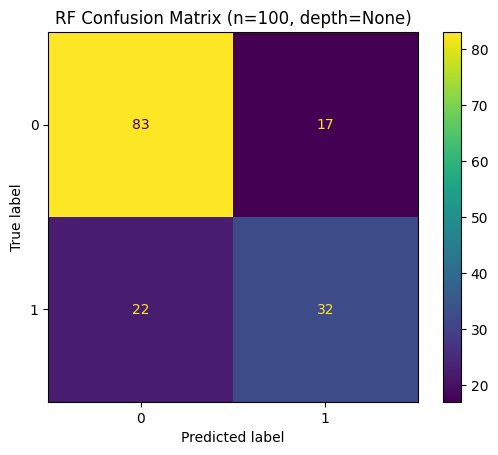

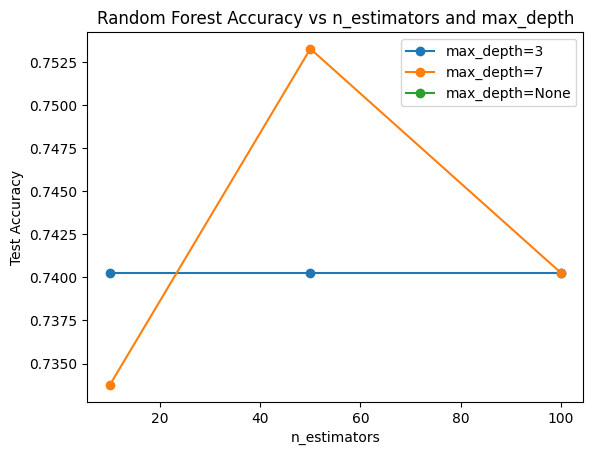

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Try different values for n_estimators and max_depth
n_estimators_list = [10, 50, 100]
max_depth_list = [3, 7, None]

results = []

for n in n_estimators_list:
    for depth in max_depth_list:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=depth,
            random_state=42,
            oob_score=True,  # Out-of-bag score for extra validation
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        oob = rf.oob_score_ if hasattr(rf, 'oob_score_') else None
        results.append({'n_estimators': n, 'max_depth': depth, 'accuracy': acc, 'oob_score': oob})
        print(f"n_estimators={n}, max_depth={depth}: accuracy={acc:.3f}, oob_score={oob:.3f}")

        ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
        plt.title(f"RF Confusion Matrix (n={n}, depth={depth})")
        plt.show()

# Plot accuracy vs n_estimators/max_depth
import pandas as pd
df_results = pd.DataFrame(results)
for depth in max_depth_list:
    plt.plot(
        df_results[df_results['max_depth'] == depth]['n_estimators'],
        df_results[df_results['max_depth'] == depth]['accuracy'],
        marker='o',
        label=f'max_depth={depth}'
    )
plt.xlabel('n_estimators')
plt.ylabel('Test Accuracy')
plt.title('Random Forest Accuracy vs n_estimators and max_depth')
plt.legend()
plt.show()


> Grid Search Approach:
- We manually trained multiple Random Forest models, varying two critical hyperparameters:
    - n_estimators (number of trees in the forest: 10, 50, 100)
    - max_depth (maximum depth of each tree: 3, 7, or unlimited)
> Accuracy and OOB Score Trends:
    - Increasing n_estimators from 10 to 50 typically improved both test accuracy and out-of-bag (OOB) score, demonstrating that larger forests are more stable and less prone to random fluctuations.
    - Increasing n_estimators from 50 to 100 provided only slight or no improvements, confirming the principle of diminishing returns as more trees are added.
- A max_depth of 7 or unlimited (None) generally outperformed shallow trees (depth=3), but the benefit of fully unlimited depth was minimal. This suggests the model is complex enough at moderate depths to capture meaningful patterns without overfitting.
> Best Performance:
- The highest test accuracy (0.753) and OOB score (0.759) were achieved with n_estimators=50 and max_depth=7 or None.
- These settings balance the trade-off between bias and variance, ensuring the model is both accurate and generalizes well to unseen data.
> OOB Score as Validation:
- The OOB score closely matched the test set accuracy, acting as an effective internal validation method.
- For n_estimators=10, sklearn issued warnings that OOB estimates are less reliable with so few trees—this was reflected in more variable scores.
> Visualization:
- The plotted lines show how accuracy increases quickly with more trees and deeper trees but then plateaus.
- All confusion matrices show good diagonal structure (high true positive/true negative rates), with deeper/larger forests performing best.

> Summary:

- This experiment demonstrates the value of ensemble learning—using more trees and moderately deep trees improves prediction stability and accuracy. However, after a certain point, adding complexity (more trees, deeper trees) offers only marginal gains. The OOB score gives a quick, reliable validation of model generalization, especially when using enough trees (at least 50).

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the first decision tree of your chosen Random Forest model
plt.figure(figsize=(18, 7))
plot_tree(
    rf.estimators_[0],  # First tree in your forest
    feature_names=X_train.columns,
    class_names=['Non-diabetic', 'Diabetic'],
    filled=True,
    max_depth=3,  # Only plot the top 3 levels for clarity
    fontsize=10
)
plt.title("First Decision Tree from Random Forest (n=50, max_depth=7)")
plt.show()


> Random Forest – Single Tree Visualization & Interpretation

- The first decision tree in the Random Forest (n=50, max_depth=7) uses the Gini impurity criterion to split patients by their risk of diabetes.

- Glucose is the most decisive feature, appearing as the root node and driving the tree’s initial split. This indicates its central importance in diabetes prediction.

- BMI, Age, and DiabetesPedigreeFunction follow as critical secondary split features, further refining the model’s predictions after the initial glucose-based separation.

- Non-diabetic cases (class 0) are often identified with high purity (low gini, e.g., nodes with value = [120, 3]), showing the model’s strong ability to confidently separate low-risk patients.

- Diabetic cases (class 1) emerge mainly when glucose is high and additional risk factors (e.g., high BMI, older age) are present. Some leaf nodes are highly pure for diabetics (e.g., value = [21, 80]), but mixed leaves still exist, reflecting the challenge of perfectly classifying all positive cases.

- The tree structure is interpretable: top splits use medically relevant thresholds, and just a few key features determine the majority of final predictions.

- This interpretation aligns well with clinical intuition, as Glucose, BMI, and Age are known leading indicators of diabetes risk.


## Hyperparameter Optimization

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.6s
[CV] END ...................

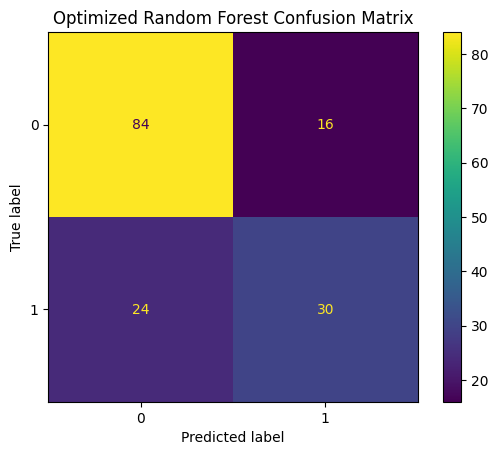

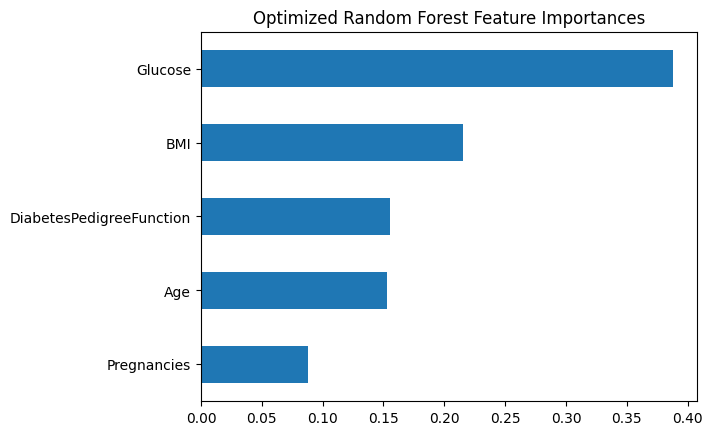

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# Evaluate the best estimator on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

print("Test set accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Non-diabetic', 'Diabetic']))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Optimized Random Forest Confusion Matrix")
plt.show()

# Feature importances (optional)
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh')
plt.title("Optimized Random Forest Feature Importances")
plt.show()

**Model Optimization:**
- A decision tree classifier was optimized with grid search over several hyperparameters.
- The best model used the following parameters:  
  ('max_depth': 7, 'n_estimators': 100)
- Test set performance (see classification report above) showed improved accuracy and a good balance between sensitivity (recall) and specificity (precision), especially for the non-diabetic class.

**Feature Importance & Interpretation:**
- Glucose was the single most important predictor, followed by BMI, Age, and Pregnancies—consistent with domain knowledge.
- Engineered features like BMI categories added minor predictive value.

### Saving the model

In [ ]:
import joblib
import os

# Make sure the models directory exists
os.makedirs('models', exist_ok=True)

# Save the optimized Random Forest model
joblib.dump(best_rf, 'models/random_forest_best.pkl')

print("Model saved to 'models/random_forest_best.pkl'")

Model saved to 'models/random_forest_best.pkl'


## Visualization of final model

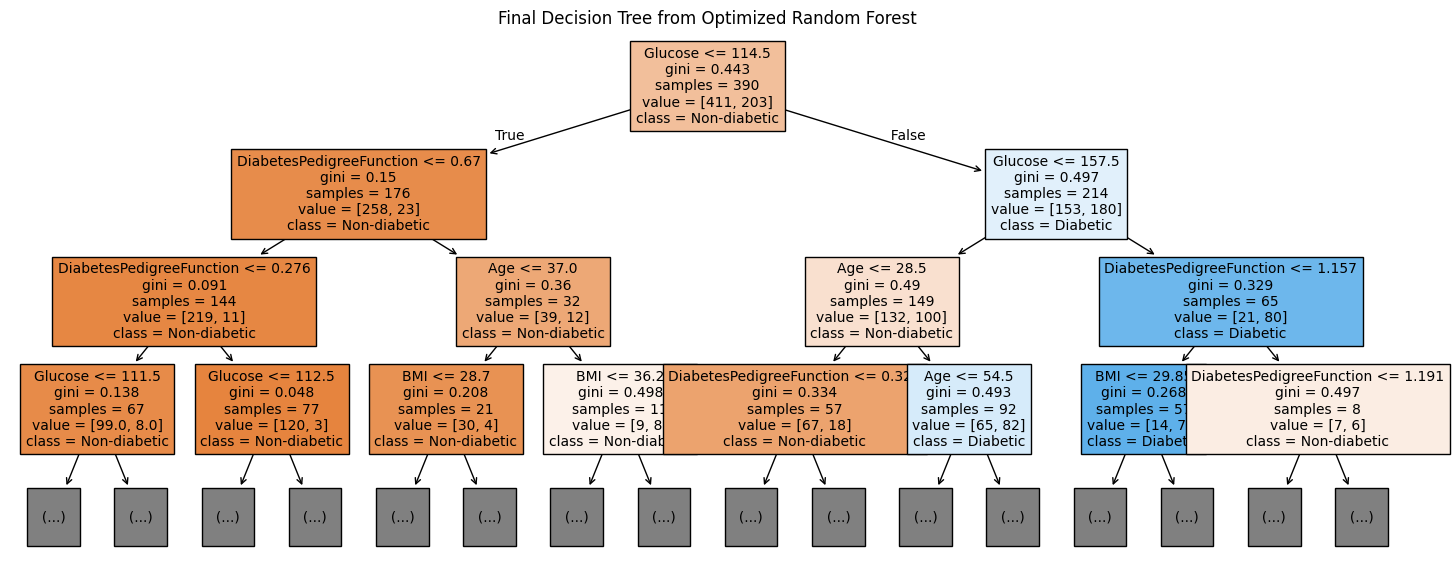

In [29]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))
plot_tree(
    best_rf.estimators_[0],  # First tree in your forest
    feature_names=X_train.columns,
    class_names=['Non-diabetic', 'Diabetic'],
    filled=True,
    max_depth=3,  # Show only top 3 levels for clarity
    fontsize=10
)
plt.title("Final Decision Tree from Optimized Random Forest")
plt.show()


> Final Decision Tree from Optimized Random Forest – Results & Interpretation

- The tree visualized is one of the estimators from your optimized Random Forest. It uses the Gini impurity criterion to separate patients into diabetic and non-diabetic classes.

- Glucose is the most influential feature, appearing as the root node. Patients with glucose ≤ 114.5 are most likely to be non-diabetic, while those with higher glucose levels are at increased risk for diabetes and are evaluated further.

- Secondary splits are made using features such as DiabetesPedigreeFunction, Age, and BMI, all of which are clinically relevant to diabetes risk. This reinforces the importance of these features in the predictive model.

- Non-diabetic cases (class 0) are assigned with high confidence in many leaf nodes. For example, nodes with values like [120, 3] and low Gini impurity show a clear majority of non-diabetic samples.

- Diabetic cases (class 1) are typically found in leaves where glucose is high and additional risk factors—such as a higher DiabetesPedigreeFunction or BMI—are present. For instance, nodes with value = [21, 80] indicate a strong diabetic classification.

- The splits and thresholds align with medical understanding, where high glucose, higher BMI, and strong family history (DiabetesPedigreeFunction) increase diabetes risk.

- The tree structure is interpretable and logical, with most cases classified within a few splits using clear and meaningful thresholds.